**importing libraries**

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt

# Web scraping from: https://wine.com
**functions to get all the info about the products**

In [2]:
def url_contructor(page_number, url):
    first = url.split('7155', 1)[0]
    second = url.split('7155',1)[1]
    url = first + '7155/' + str(page_number) + second
    return url

In [3]:
def web_scrap():
    page = 0
    url_df = []
    web_data = {'product_name': [],
                'year':[],
                'varietal': [],
                'origin': [],
                'price': [],
                'rating': [],
                'rating_count':[]}
    df = pd.DataFrame(data=web_data)
    url = 'https://www.wine.com/list/wine/7155?pricemin=10&ratingmin=89'
    for x in range(1, 150):
        try:
            page += 1
            url_df.append(url_contructor(page, url))
        except Exception:
            continue
    for link in url_df:
        r = requests.get(link)
        soup = BeautifulSoup(r.content, 'html.parser')
        all_li = soup.find_all('li', {'class': 'prodItem'})
        for li in all_li:
            product_name = li.find('span', class_= 'prodItemInfo_name').string
            year = product_name.split()[-1]
            product_name = product_name.rsplit(' ', 1)[0]
            price = li.find('span', class_='productPrice_price-regWhole').string
            varietal = li.find('span', class_='prodItemInfo_varietal').string
            origin = li.find('span', class_='prodItemInfo_originText').string
            origin = origin.split()[-1]
            rating = li.find('span', class_='averageRating_average').string
            rating_count = li.find('span', class_='averageRating_number').string
            series = [product_name,year,varietal,origin,price,rating,rating_count]
            df.loc[len(df)]=series
    return df

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import undetected_chromedriver as uc

def web_scrap_selenium():
    page = 0
    url_df = []
    web_data = {'product_name': [],
                'year':[],
                'varietal': [],
                'origin': [],
                'price': [],
                'rating': [],
                'rating_count':[]}
    df = pd.DataFrame(data=web_data)
    url = 'https://www.wine.com/list/wine/7155?pricemin=10&ratingmin=89'
    
    # Use Chrome webdriver
    driver = uc.Chrome()
    
    # Wait for the page to load
    wait = WebDriverWait(driver, 10)
    
    for x in range(1, 150):
        try:
            page += 1
            url_df.append(url_constructor(page, url))
        except Exception:
            continue
            
    for link in url_df:
        driver.get(link)
        
        # Wait until the page has finished loading
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, "prodItem")))
        
        # Get the page source
        html = driver.page_source
        
        # Parse the page source with BeautifulSoup
        soup = BeautifulSoup(html, 'html.parser')
        
        # Find all product items on the page
        all_li = soup.find_all('li', {'class': 'prodItem'})
        
        # Extract the relevant information from each product item
        for li in all_li:
            product_name = li.find('span', class_= 'prodItemInfo_name').string
            year = product_name.split()[-1]
            product_name = product_name.rsplit(' ', 1)[0]
            price = li.find('span', class_='productPrice_price-regWhole').string
            varietal = li.find('span', class_='prodItemInfo_varietal').string
            origin = li.find('span', class_='prodItemInfo_originText').string
            origin = origin.split()[-1]
            rating = li.find('span', class_='averageRating_average').string
            rating_count = li.find('span', class_='averageRating_number').string
            
            # Add the extracted information to the DataFrame
            series = [product_name,year,varietal,origin,price,rating,rating_count]
            df.loc[len(df)]=series
            
    # Close the webdriver
    driver

**run to update DataFrame**

In [5]:
#df = web_scrap_selenium()

In [6]:
#df.to_csv('wine.csv')

**loading DataFrame**

In [7]:
df = pd.read_csv('wine.csv', index_col=0)
df

,product_name,year,varietal,origin,price,rating,rating_count
0,Dom Perignon Vintage with Gift Box,2012,Vintage Sparkling Wine,France,269,4.8,37
1,Robert Mondavi To Kalon Vineyard Reserve Caber...,2017,Cabernet Sauvignon,California,144,4.6,34
2,Chateau Fonbadet B de Fonbadet,2019,Bordeaux Red Blends,France,24,3.8,31
3,Joseph Phelps Cabernet Sauvignon,2019,Cabernet Sauvignon,California,89,4.5,46
4,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,77,4.4,72
...,...,...,...,...,...,...,...
3695,Wolffer Finca Wolffer Rose,2021,Rosé,Argentina,16,3.7,23
3696,Erath Leland Vineyard Pinot Noir,2018,Pinot Noir,Oregon,42,0.0,0
3697,Pendulum Cabernet Sauvignon,2020,Cabernet Sauvignon,Washington,16,4.1,7
3698,Chalk Hill Sonoma Coast Pinot Noir,2019,Pinot Noir,California,26,3.6,8


# Cleaning data for plots and machine learning

**removing products with no rating or not enough ratings**

In [8]:
df = df[df['rating'] != 0]
df = df[df['rating_count'] > 20]

**converting strings to integers**  

In [9]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()]
df['price']=df['price'].str.replace(',','')
df = df.astype({'price':'int'})
df = df.astype({'rating':'float'})
df['year'] = pd.to_numeric(df['year'])

**taking all the products from 2014 and above** 

In [10]:
df = df[df['year'] > 2014] #2014
df = df[df['year'] < 2021]
df = df.reset_index(drop=True)

**removing products that appear below the minimum times**\

In [11]:
df = df.groupby('varietal').filter(lambda x : len(x)>20).reset_index(drop=True) #20
df = df.groupby('origin').filter(lambda x : len(x)>5).reset_index(drop=True) #5

**removing duplicates**

In [12]:
df = df.drop_duplicates(subset=['product_name'])

**adding categorical codes**

In [13]:
df['varietal_code'] = df['varietal'].astype('category').cat.codes
df['origin_code'] = df['origin'].astype('category').cat.codes
df

,product_name,year,varietal,origin,price,rating,rating_count,varietal_code,origin_code
0,Robert Mondavi To Kalon Vineyard Reserve Caber...,2017,Cabernet Sauvignon,California,144,4.6,34,1,2
1,Chateau Fonbadet B de Fonbadet,2019,Bordeaux Red Blends,France,24,3.8,31,0,4
2,Joseph Phelps Cabernet Sauvignon,2019,Cabernet Sauvignon,California,89,4.5,46,1,2
3,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,77,4.4,72,1,2
4,Faust Cabernet Sauvignon,2018,Cabernet Sauvignon,California,55,4.3,427,1,2
...,...,...,...,...,...,...,...,...,...
358,Clos de Nit Crianza,2016,Other Red Blends,Spain,13,3.6,38,3,7
359,Tikal Patriota,2018,Other Red Blends,Argentina,21,3.8,33,3,0
360,Vigilance Cimarron,2017,Other Red Blends,California,12,3.7,120,3,2
361,William Hill North Coast Cabernet Sauvignon,2019,Cabernet Sauvignon,California,14,3.9,34,1,2


# Plotting some usefull info 

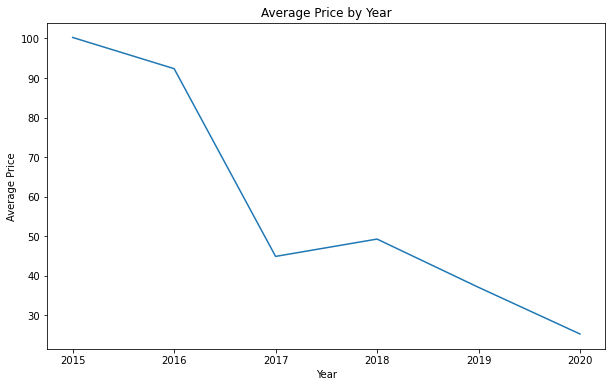

In [14]:
price_by_year = df.groupby('year')['price'].mean().reset_index()
x = price_by_year['year']
y = price_by_year['price']
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.title('Average Price by Year')

# Show the plot
plt.show()

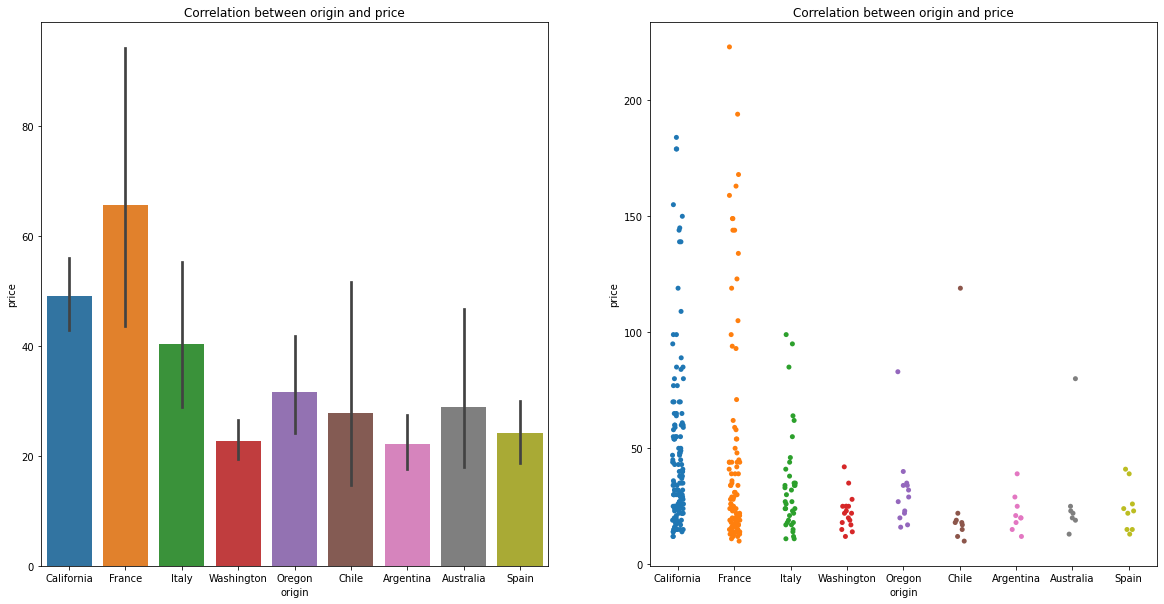

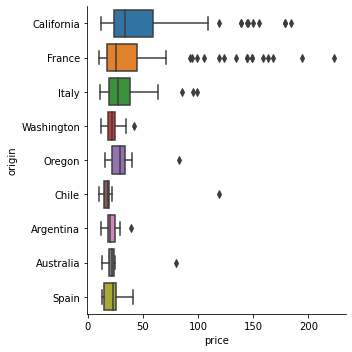

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.barplot(x = 'origin', y = 'price', data = df,ax=ax1)
sns.stripplot(data=df.drop(df[df.price >= 250].index), x="origin", y="price",ax=ax2)
ax1.set_title('Correlation between origin and price')
ax2.set_title('Correlation between origin and price')
sns.catplot(data=df.drop(df[df.price >= 250].index), x="price", y="origin",kind="box")
plt.show()

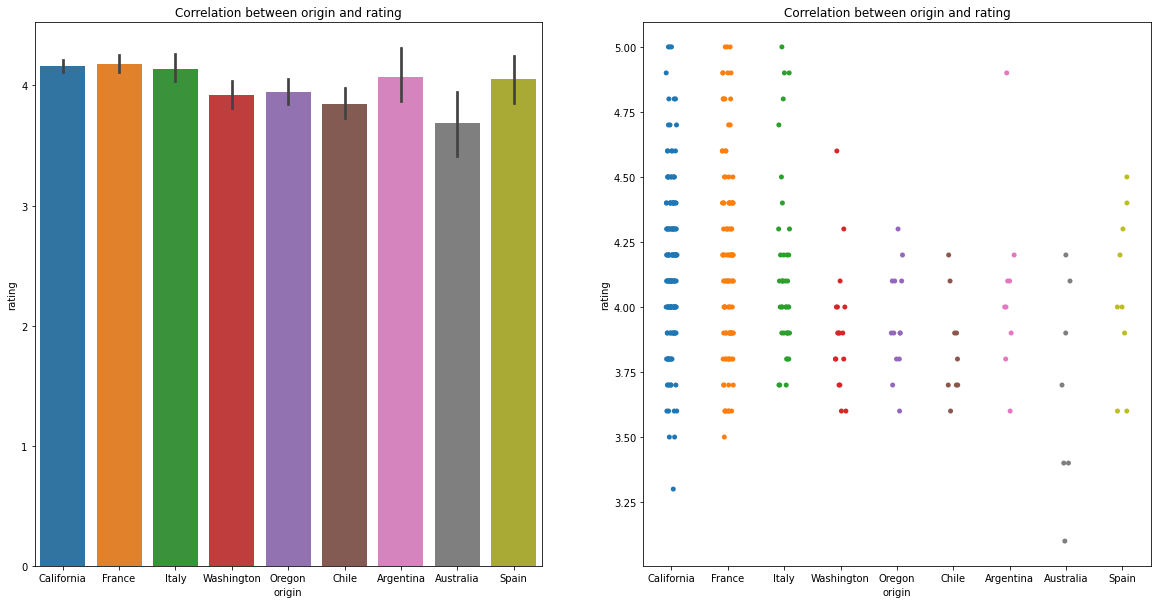

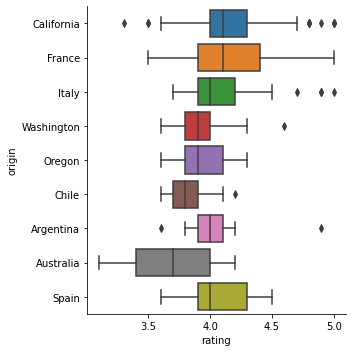

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
sns.barplot(x = 'origin', y = 'rating', data = df,ax=ax1)
sns.stripplot(data=df, x="origin", y="rating",ax=ax2)
ax1.set_title('Correlation between origin and rating')
ax2.set_title('Correlation between origin and rating')
sns.catplot(data=df.drop(df[df.price >= 250].index), x="rating", y="origin",kind="box")
plt.show()

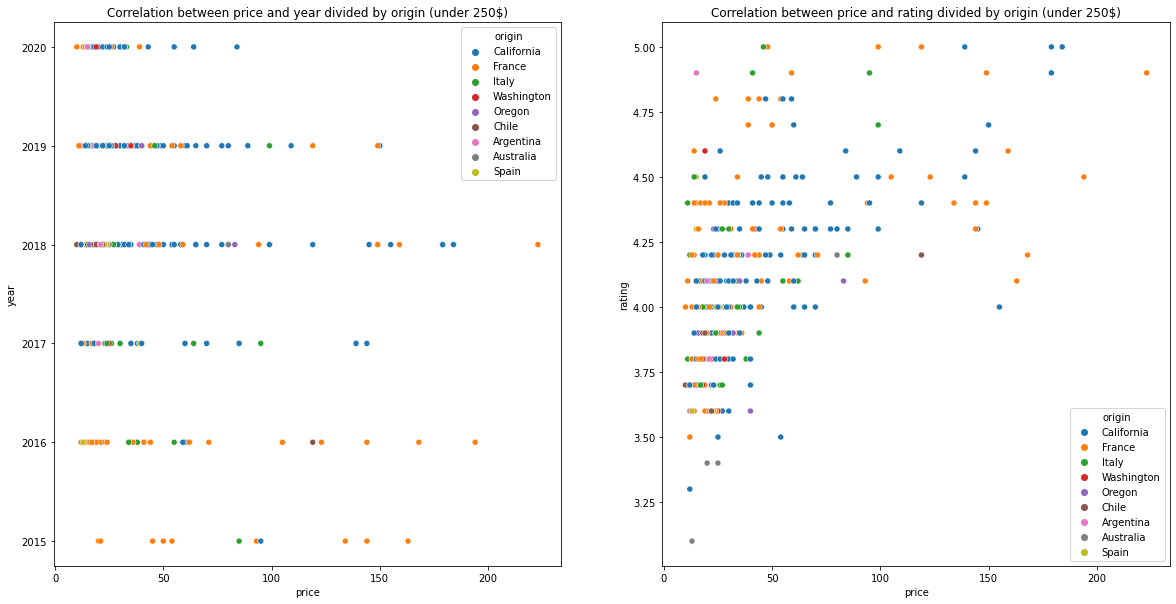

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(data=df.drop(df[df.price >= 250].index), x="price", y="year",hue="origin",ax =ax1)
sns.scatterplot(data=df.drop(df[df.price >= 250].index), x="price", y="rating",hue="origin",ax =ax2)
ax1.set_title('Correlation between price and year divided by origin (under 250$)')
ax2.set_title('Correlation between price and rating divided by origin (under 250$)')
plt.show()

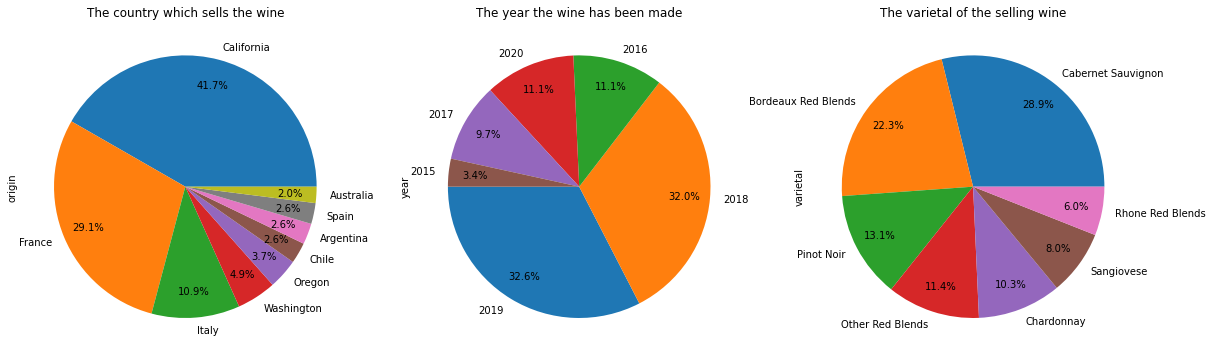

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))
df['origin'].value_counts().plot.pie(y='origin', figsize=(8, 8),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax1)
df['year'].value_counts().plot.pie(y='year', figsize=(8, 8),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax2,startangle=180)
df['varietal'].value_counts().plot.pie( figsize=(5, 10),subplots=True,autopct='%1.1f%%', pctdistance=0.8,ax=ax3)
ax1.set_title("The country which sells the wine")
ax2.set_title('The year the wine has been made')
ax3.set_title('The varietal of the selling wine')
plt.show()

**adding rating_code to predict the wine worth**

In [19]:
df['rating'].value_counts()
names = ['poor', 'high']
bins = (3.0, 4.1, 5.0)
df['quality'] = pd.cut(df['rating'], bins = bins, labels = names)
df

,product_name,year,varietal,origin,price,rating,rating_count,varietal_code,origin_code,quality
0,Robert Mondavi To Kalon Vineyard Reserve Caber...,2017,Cabernet Sauvignon,California,144,4.6,34,1,2,high
1,Chateau Fonbadet B de Fonbadet,2019,Bordeaux Red Blends,France,24,3.8,31,0,4,poor
2,Joseph Phelps Cabernet Sauvignon,2019,Cabernet Sauvignon,California,89,4.5,46,1,2,high
3,Stag's Leap Wine Cellars Artemis Cabernet Sauv...,2019,Cabernet Sauvignon,California,77,4.4,72,1,2,high
4,Faust Cabernet Sauvignon,2018,Cabernet Sauvignon,California,55,4.3,427,1,2,high
...,...,...,...,...,...,...,...,...,...,...
358,Clos de Nit Crianza,2016,Other Red Blends,Spain,13,3.6,38,3,7,poor
359,Tikal Patriota,2018,Other Red Blends,Argentina,21,3.8,33,3,0,poor
360,Vigilance Cimarron,2017,Other Red Blends,California,12,3.7,120,3,2,poor
361,William Hill North Coast Cabernet Sauvignon,2019,Cabernet Sauvignon,California,14,3.9,34,1,2,poor


**visualizing rating_code**

poor    203
high    147
Name: quality, dtype: int64

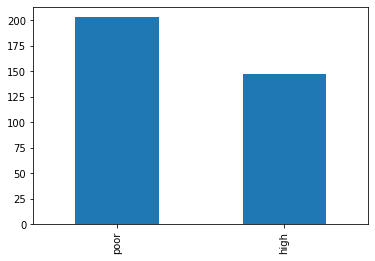

In [20]:
df['quality'].value_counts().plot.bar()
df['quality'].value_counts()


# Starting machine learning

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['quality'] = le.fit_transform(df['quality'])

**dividing to independent and dependent variables**

In [22]:
X = df.drop(columns=['rating','product_name','varietal','origin','quality'])
y = df['quality']

**creating classify function to match all the modeles**

In [23]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
def classify(model, X, y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)
    # train the model
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    print("Accuracy:", accuracy * 100)
    
    # predicting the results for the test set
    y_pred = model.predict(x_test)
    
    # cross-validation
    score = cross_val_score(model, X, y, cv=5)
    print("CV Score:", np.mean(score)*100)
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix,columns = ['0', '1'])
    print(matrix)
    matrix.plot.bar()    
    return model, y_pred, accuracy

In [24]:
models = []
models_accuracies = []

**Logistic Regression**

Accuracy: 73.76425855513308
CV Score: 76.85714285714286
    0    1
0  62   49
1  20  132


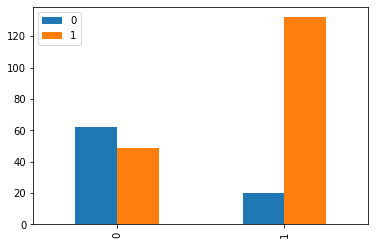

In [25]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
trained_model, y_pred_lr , accuracy_lr = classify(logistic_regression, X, y)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Decision Tree Classifier**

Accuracy: 68.06083650190115
CV Score: 68.57142857142857
    0    1
0  76   35
1  49  103


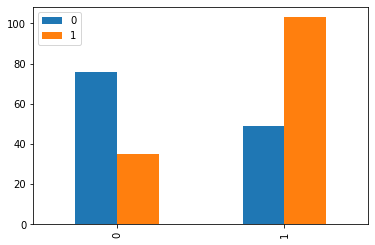

In [26]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
trained_model, y_pred_dt , accuracy_dt = classify(decision_tree, X, y)
models.append(trained_model)
models_accuracies.append(accuracy_dt)

**Random Forest Classifier**

Accuracy: 77.56653992395437
CV Score: 76.0
    0    1
0  77   34
1  25  127


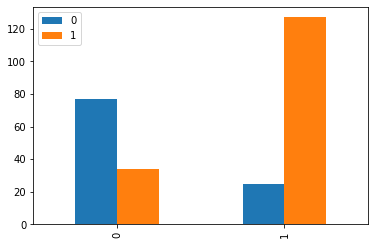

In [27]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
trained_model, y_pred_rf , accuracy_rf = classify(random_forest, X, y)
models.append(trained_model)
models_accuracies.append(accuracy_rf)

**Extra Trees Classifier**

Accuracy: 74.1444866920152
CV Score: 72.85714285714286
    0    1
0  66   45
1  23  129


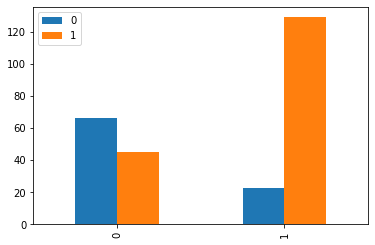

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
extra_trees_model = ExtraTreesClassifier()
trained_model, y_pred_et , accuracy_et = classify(extra_trees_model, X, y)
models.append(trained_model)
models_accuracies.append(accuracy_et)

**Multi-layer Perceptron classifier**

Accuracy: 65.77946768060836
CV Score: 74.57142857142858
    0    1
0  23   88
1   2  150


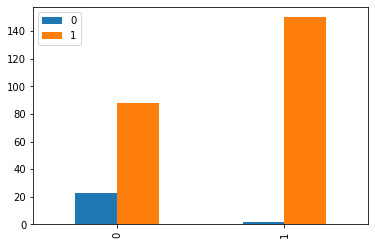

In [29]:
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier()
trained_model, y_pred_lr , accuracy_lr = classify(nn_model, X, y)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Support Vector Classifier**

Accuracy: 76.04562737642586
CV Score: 76.85714285714286
    0    1
0  65   46
1  17  135


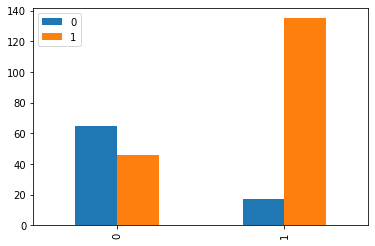

In [30]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
trained_model, y_pred_lr , accuracy_lr = classify(svm_model, X, y)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**K Neighbors Classifier**

Accuracy: 73.76425855513308
CV Score: 71.71428571428572
    0    1
0  66   45
1  24  128


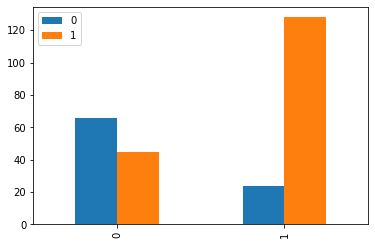

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
trained_model, y_pred_lr , accuracy_lr = classify(knn_model, X, y)
models.append(trained_model)
models_accuracies.append(accuracy_lr)

**Model scores**

In [32]:
models_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Extra Trees', 'MLP', 'SVC', 'K Neighbors']
for model, acc in zip(models_names, models_accuracies):
    print(f'Model: {model}, score: {acc} ')

Model: Logistic Regression, score: 0.7376425855513308 
Model: Decision Tree, score: 0.6806083650190115 
Model: Random Forest, score: 0.7756653992395437 
Model: Extra Trees, score: 0.7414448669201521 
Model: MLP, score: 0.6577946768060836 
Model: SVC, score: 0.7604562737642585 
Model: K Neighbors, score: 0.7376425855513308 


**Plotting models accuracies**

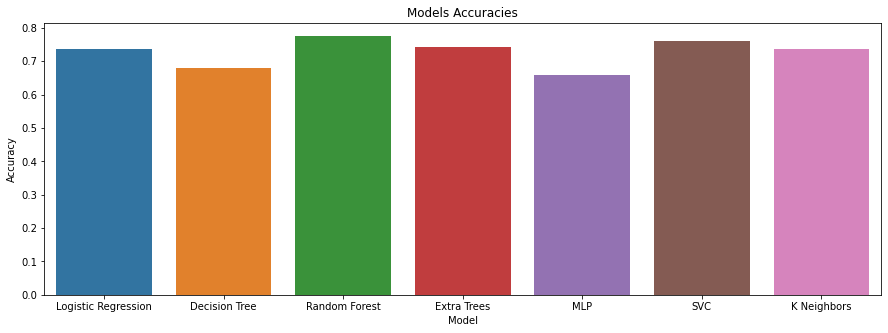

In [33]:
plt.figure(figsize=(15,5))
sns.barplot(x=models_names, y=models_accuracies)
plt.title('Models Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

**Best model**

In [34]:
max_index = models_accuracies.index(max(models_accuracies))
best_model = models[max_index]
best_model

RandomForestClassifier()

In [35]:
def predict_quality(df, model):
    X = df[['year', 'price','rating_count', 'varietal_code', 'origin_code']]
    y_pred = model.predict(X)
    wine_df['predicted_quality'] = y_pred
    return df

**Trying to predict the quality of a dataframe**

In [36]:
data = {
    'product_name': ['Wine 1', 'Wine 2', 'Wine 3', 'Wine 4', 'Wine 5'],
    'year': [2019, 2018, 2017, 2016, 2015],
    'varietal': ['Cabernet Sauvignon', 'Other Red Blends', 'Bordeaux Red Blends', 'Bordeaux Red Blends', 'Other Red Blends'],
    'origin': ['California', 'Oregon', 'France', 'Spain', 'Oregon'],
    'price': [89, 30, 35, 40, 50],
    'rating_count': [75, 88, 125, 200, 24]
}

wine_df = pd.DataFrame(data)
wine_df['varietal_code'] = wine_df['varietal'].astype('category').cat.codes
wine_df['origin_code'] = wine_df['origin'].astype('category').cat.codes

In [37]:
wine_df= predict_quality(wine_df,best_model)
wine_df

,product_name,year,varietal,origin,price,rating_count,varietal_code,origin_code,predicted_quality
0,Wine 1,2019,Cabernet Sauvignon,California,89,75,1,0,0
1,Wine 2,2018,Other Red Blends,Oregon,30,88,2,2,1
2,Wine 3,2017,Bordeaux Red Blends,France,35,125,0,1,1
3,Wine 4,2016,Bordeaux Red Blends,Spain,40,200,0,3,1
4,Wine 5,2015,Other Red Blends,Oregon,50,24,2,2,0
